In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt
%matplotlib inline

# 4.2 損失関数

### 2乗和誤差

***

$$
E = \frac{1}{2} \sum_{k} (y_k - t_k)^2
$$
$ y_k $ : ニューラルネットワークの出力

$ t_k $ : 教師データ (one-hot表現)

***

- 一つのデータに対する関数．データ全体に渡って和を取り，データ数で割る．

- 先頭の1/2は微分したときに式を単純にするため．

- 手書き文字認識(0-9)であれば，$ k = 0,  \ldots, 9 $

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])

In [4]:
mean_squared_error(y, t)

0.09750000000000003

### 交差エントロピー誤差

***

$$
E = - \sum_{k} t_k \log y_k
$$
$ y_k $ : ニューラルネットワークの出力

$ t_k $ : 教師データ (one-hot表現)

***

- 一つのデータに対する関数．データ全体に渡って和を取り，データ数で割る．

- logは自然対数．

- 教師データがone-hot表現であれば，正解ラベルのインデックスの出力のみを計算することに等しい．

- 正解ラベルのインデックスの出力が1に近いほど，エントロピー誤差は0に近づく

- 手書き文字認識(0-9)であれば，$ k = 0,  \ldots, 9 $

In [5]:
x = np.arange(0, 1, 0.01)
x = x[1:]

Text(0.5, 1.0, 'y = - log x')

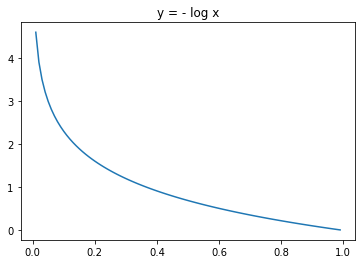

In [6]:
plt.plot(x, -np.log(x))
plt.title('y = - log x')

In [7]:
def cross_entropy_error(y, t):
    delta = 1e-7 # logの真数に0が入らないように，微小量を足す
    return -np.sum(t * np.log(y + delta))

### ミニバッチ学習

上記誤差関数を少し変形し，N個のデータの損失関数をまとめて計算する

訓練データのすべてのデータの交差エントロピー誤差の和を求める

***
$$
E = - \frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log y_{nk}
$$

$ n = 0, \ldots , N $ : データのインデックス

$ k = 0, \ldots , 9 $ : ラベルのインデックス
***

- 交差エントロピー誤差のデータ数 $ N $ 個の平均を取る．

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000,)


In [9]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### バッチ処理対応版 交差エントロピー誤差

In [21]:
# ===== 教師データが one-hot 表現の場合 =====
def cross_entropy_error(y, t):
    # データ数が1つの場合は2次元に直す
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    # バッチ全体の和を取り，バッチサイズで割る
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# ===== 教師データがラベルとして与えられた場合 =====
# def cross_entropy_error(y, t):
#     # データ数が1つの場合は2次元に直す
#     if y.ndim == 1:
#         t = t.reshape(1, t.size)
#         y = y.reshape(1, y.size)
        
#     batch_size = y.shape[0]
#     # バッチ全体の和を取り，バッチサイズで割る
#     return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 4.3 数値微分

### 微分
$$
\frac{df}{dx} = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
$$
***
- x における傾きを表す

***

### 数値微分の実装
- 微小量として0.0001を使う(小さすぎると丸め誤差が発生する)
- $x \pm h$ で微分を計算する中心差分を使う

In [11]:
# 数値微分実装
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

次の関数の微分を計算してみる
$$
y = 0.01x^2 + 0.1x
$$

In [12]:
def func_1(x):
    return 0.01*x**2 + 0.1*x

In [13]:
numerical_diff(func_1, 5)

0.1999999999990898

In [14]:
numerical_diff(func_1, 10)

0.2999999999986347

***
$ y = 0.01x^2 + 0.1x $ と，$ x = 5, 10 $ における接線の可視化

0.1999999999990898
0.2999999999986347


Text(0, 0.5, 'y')

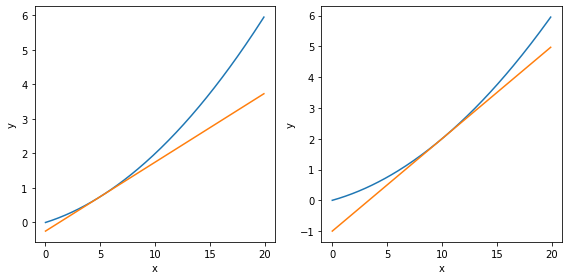

In [15]:
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = func_1(x)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

tf = tangent_line(func_1, 5)
y2 = tf(x)
axes[0].plot(x, y)
axes[0].plot(x, y2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

tf = tangent_line(func_1, 10)
y2 = tf(x)
axes[1].plot(x, y)
axes[1].plot(x, y2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

### 偏微分
変数が複数ある場合に，一つ一つの変数に着目して微分を求める

$$
f(x_0, x_1) = {x_0}^2 + {x_1}^2
$$

上式の $x_0$ に関する偏微分は，$x_1$ を定数として考えて次のように計算する

$$
\frac{\partial f}{\partial x_0} = \frac{f(x_0 + h, x_1) - f(x_0, x_1)}{h}
$$

***

### 勾配
全ての変数に関する偏微分をまとめてベクトルにしたもの

$ f(x_0, x_1) = {x_0}^2 + {x_1}^2 $ の勾配は

$$
(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1})
$$

***

In [16]:
def func_2(x):
    """
    引数はnumpy配列が入力される想定
    """
    return np.sum(x**2)

勾配を返す関数numerical_gradientを実装

In [55]:
def numerical_gradient(f, x):
    """
    f: 勾配を計算する関数
    x: 勾配を計算する変数の値 (numpy配列)
    """
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す
        
    return grad

In [56]:
numerical_gradient(func_2, np.array([3., 4.]))

array([6., 8.])

In [57]:
numerical_gradient(func_2, np.array([0., 2.]))

array([0., 4.])

In [59]:
numerical_gradient(func_2, np.array([3., 0.]))

array([6., 0.])